### Package import & function definition

In [6]:
import pandas as pd
from sys import argv
from datetime import datetime
import os
import tkinter
from tkinter import filedialog
import pymysql
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pandas_profiling import ProfileReport
import calplot
#from pandasql import sqldf
#from scipy.interpolate import make_interp_spline, BSpline


# Allow jupyter notebook to draw plots in inline
%matplotlib inline
# Enable retina display resolution options
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['axes.unicode_minus'] = False
#fontprop = fm.FontProperties(fname='/Library/Fonts/Arial Unicode.ttf', size=18)
#fm._rebuild()
plt.rc('font', family='AppleGothic')

def logger(*args):
    """
        Print log message with excecuting file name, timestamp.
        *** All parameters should be on string-type!
    """
    try: __file__
    except NameError:
        message = f"[{str(datetime.now())}] {str(' '.join(args))}"
    else:
        message = f"[{__file__} {str(datetime.now())}] {str(' '.join(args))}"
    print(message)

def connectDB():
    """
       Connect to MySQL database server, returning connection & cursor objects. 
    """
    try:
        connection = pymysql.connect(host=keys.HOST, port=keys.PORT, 
                                    user=keys.USERNAME, password=keys.PASSWORD, 
                                    database=keys.DBNAME)
        cursor = connection.cursor()
        logger('DB connection Established.')
        return connection, cursor
    except Exception as e:
        msg = f'DB connection failed! ERROR: {str(e)}'
        logger(msg)

def askDialogue(question, statement, completeMessage=None, failureMessage=None):
    while True:
        userResponse = input(f'{str(question)} [y/n]\t').lower()
        if userResponse in ['yes', 'y', True]:
            statement
            if completeMessage != None:
                logger(f'{str(completeMessage)}')
            break
        elif userResponse in ['no', 'n', False]:
            if failureMessage != None:
                logger(f'{str(failureMessage)}')
            break
        else:
            print('Wrong response')

#pysqldf = lambda q: sqldf(q, globals())

currentPath = globals()['_dh'][0]

def getDframeName(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def saveDataframe(df, fileName=None): 
    if fileName == None: fileName = getDframeName(df)+'.csv'
    df.to_csv(fileName)
    logger(f"Dataframe saved as {fileName}")

def dropNumericalOutliers(df, z_thresh=3):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    import numpy as np
    from scipy import stats
    constrains = df.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, reduce=False) \
        .all(axis=1)
    # Drop (inplace) values set to be rejected
    df.drop(df.index[~constrains], inplace=True)

logger("import & definition ends successfully.")

[2021-06-08 01:34:40.734370] import & definition ends successfully.


### Load data from database

In [22]:
import keys
connection, cursor = connectDB()

logger('Select data from db server...')
query = f"""SELECT stationName, measuredDatetime, PM25
            FROM `nifos` WHERE YEAR(measuredDatetime)=2021
            ORDER BY stationName ASC, measuredDatetime ASC"""
nifos = pd.read_sql(query, connection)
display(nifos)
print(nifos.dtypes)

query = "SELECT * FROM weather ORDER BY 1 asc, 2 asc"
weather = pd.read_sql(query, connection)
display(weather)
print(weather.dtypes)

separatorColumn, datetimeColumn, dataColumn = tuple(nifos.columns)

[2021-06-08 01:49:18.659645] DB connection Established.
[2021-06-08 01:49:18.659840] Select data from db server...


,stationName,measuredDatetime,PM25
0,고매_150m,2021-01-01 00:00:00,20.100000
1,고매_150m,2021-01-01 01:00:00,22.966667
2,고매_150m,2021-01-01 02:00:00,21.083333
3,고매_150m,2021-01-01 03:00:00,18.360000
4,고매_150m,2021-01-01 04:00:00,19.250000
...,...,...,...
103968,횡성_5m,2021-03-31 19:00:00,17.866667
103969,횡성_5m,2021-03-31 20:00:00,17.766667
103970,횡성_5m,2021-03-31 21:00:00,15.783333
103971,횡성_5m,2021-03-31 22:00:00,14.566667


stationName                 object
measuredDatetime    datetime64[ns]
PM25                       float64
dtype: object


,stationName,measuredDatetime,temperature,relativeHumidity,windSpeed,windWirection
0,고매_150m,2020-01-01 00:00:00,-6.023000,48.786667,0.105368,96.517414
1,고매_150m,2020-01-01 01:00:00,-5.811167,46.939000,0.424050,106.361332
2,고매_150m,2020-01-01 02:00:00,-5.854000,48.860000,0.539179,114.490390
3,고매_150m,2020-01-01 03:00:00,-5.332667,47.245667,0.232290,69.874257
4,고매_150m,2020-01-01 04:00:00,-5.481000,52.640833,0.202981,9.181985
...,...,...,...,...,...,...
226798,횡성_5m,2021-03-31 19:00:00,10.533333,45.716667,1.276465,32.832088
226799,횡성_5m,2021-03-31 20:00:00,9.350000,50.883333,1.362853,21.718617
226800,횡성_5m,2021-03-31 21:00:00,8.900000,48.383333,1.364345,26.896192
226801,횡성_5m,2021-03-31 22:00:00,8.800000,43.416667,1.325321,19.709058


stationName                 object
measuredDatetime    datetime64[ns]
temperature                float64
relativeHumidity           float64
windSpeed                  float64
windWirection              float64
dtype: object


### Filter data which are available for winter 2021

In [23]:
targetStation = tuple(nifos[nifos[datetimeColumn].dt.strftime('%Y%m%d') == '20210101'][separatorColumn].unique())
logger(f"targetStation: {str(targetStation)}")
nifos_filtered = nifos.query(f"{separatorColumn} == {targetStation}")[nifos[datetimeColumn].dt.month <= 3]
display(nifos_filtered)

[2021-06-08 01:49:27.318365] targetStation: ('고매_150m', '고매_50m', '고매_도로', '고양_산단', '고양_숲', '고양_주거', '관악_도심', '관악_숲', '관악_캠퍼스', '기장_산단', '기장_숲', '기장_주거', '시화_산단', '시화_주거', '시화_차단숲', '양재_200m', '양재_300m', '양재_도로', '제주_10m', '제주_20m', '제주_5m', '홍릉_도심', '홍릉_숲내부5m', '홍릉_숲외부20m')


,stationName,measuredDatetime,PM25
0,고매_150m,2021-01-01 00:00:00,20.100000
1,고매_150m,2021-01-01 01:00:00,22.966667
2,고매_150m,2021-01-01 02:00:00,21.083333
3,고매_150m,2021-01-01 03:00:00,18.360000
4,고매_150m,2021-01-01 04:00:00,19.250000
...,...,...,...
99441,홍릉_숲외부20m,2021-03-31 19:00:00,14.000000
99442,홍릉_숲외부20m,2021-03-31 20:00:00,14.966667
99443,홍릉_숲외부20m,2021-03-31 21:00:00,17.400000
99444,홍릉_숲외부20m,2021-03-31 22:00:00,18.100000


### Remove outliers

In [6]:
nifos_test = nifos.copy()

def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

nifos_test['isNormal'] = Remove_Outlier_Indices(nifos_test['PM25'])
condition = nifos_test[nifos_test['isNormal'] == False].index
nifos_outlier_filtered = nifos_test.drop(condition).drop('isNormal', axis=1)

display(nifos_outlier_filtered)

,stationName,measuredDatetime,PM25
0,고매_150m,2020-01-01 00:00:00,21.046167
1,고매_150m,2020-01-01 01:00:00,21.590833
2,고매_150m,2020-01-01 02:00:00,20.475167
3,고매_150m,2020-01-01 03:00:00,19.425167
4,고매_150m,2020-01-01 04:00:00,19.658167
...,...,...,...
218264,횡성_5m,2021-03-31 19:00:00,17.866667
218265,횡성_5m,2021-03-31 20:00:00,17.766667
218266,횡성_5m,2021-03-31 21:00:00,15.783333
218267,횡성_5m,2021-03-31 22:00:00,14.566667


### Create reports using Pandas profiling

In [31]:
profile = ProfileReport(nifos_filtered, title="nifos PM25 report")
profile.to_widgets()

Generate report structure: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


### Make smoothed line plots

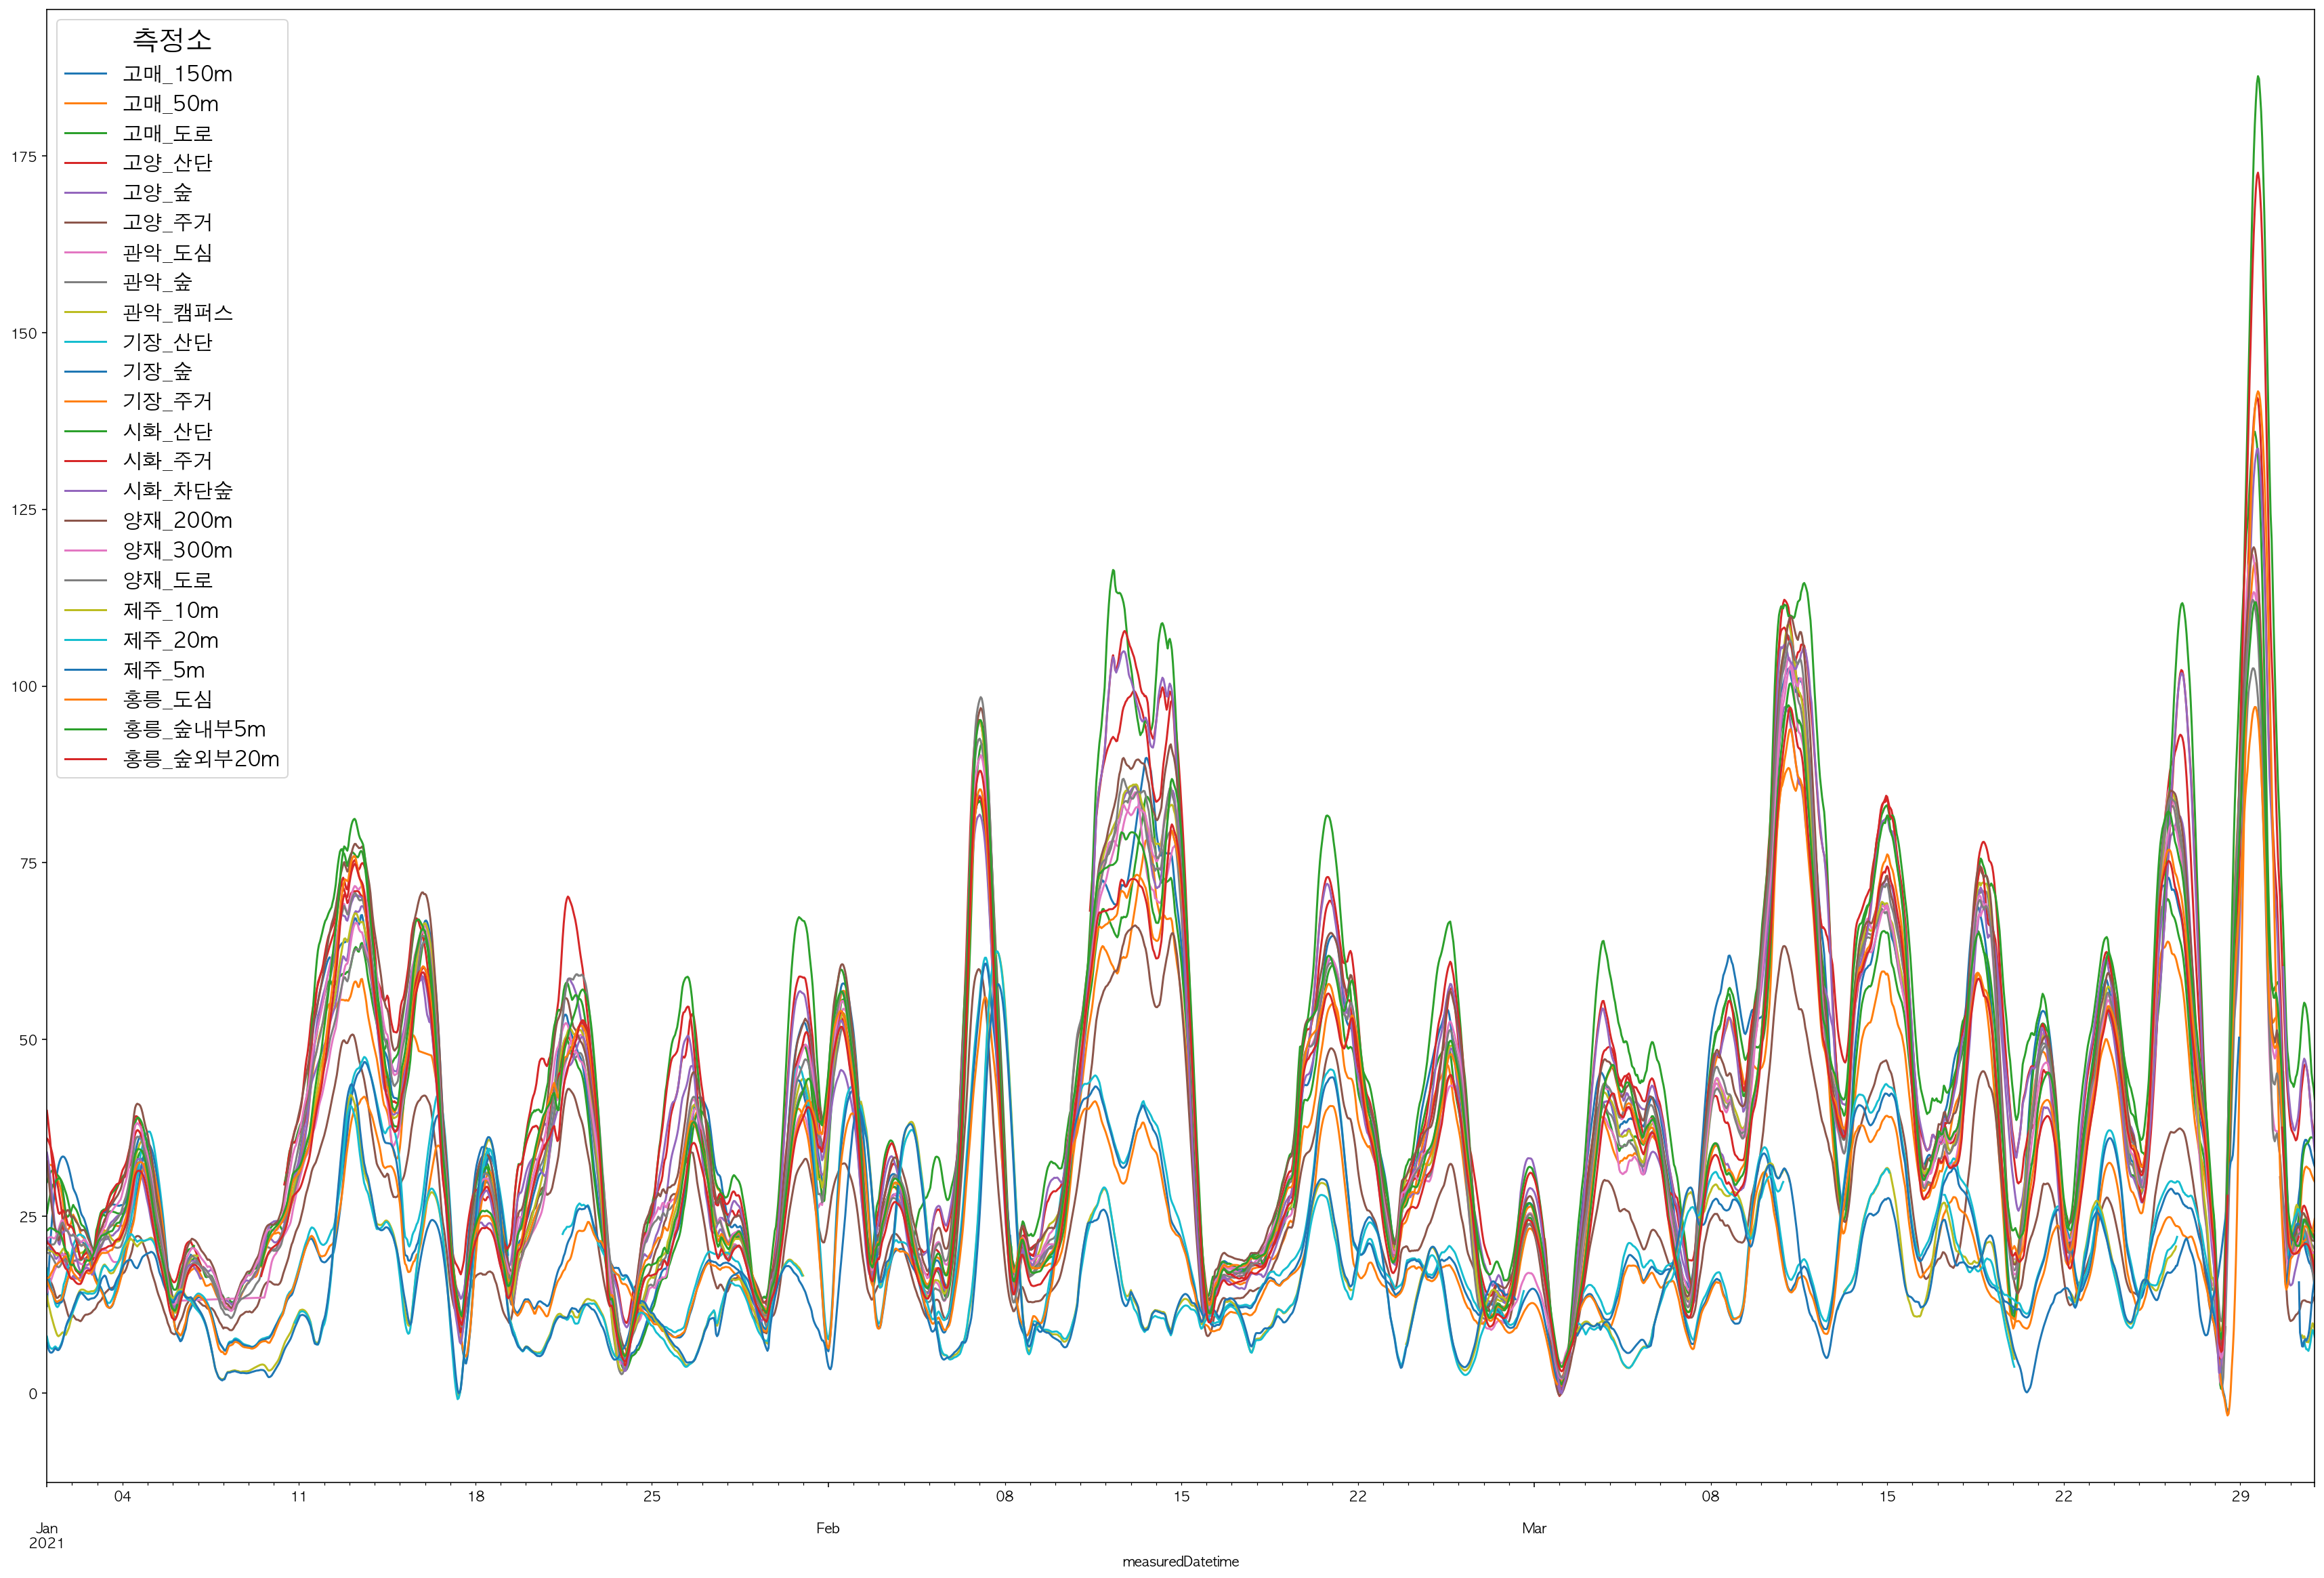

In [45]:
from scipy.signal import savgol_filter
yData = savgol_filter(nifos_filtered[dataColumn], 51, 3) # window size 51, polynomial order 3
nifos_copied = nifos_filtered.copy()
nifos_copied[dataColumn] = yData
nifos_copied.set_index(datetimeColumn).groupby(separatorColumn)[dataColumn].plot(legend=True, figsize=(30,20))
plt.legend(title="측정소", fontsize=15, title_fontsize=20)
plt.show()

### Make boxplot with filtered data

[2021-06-08 00:49:18.172634] Plot saved as 2020 & 2021년 1~3월 PM25 데이터 분포


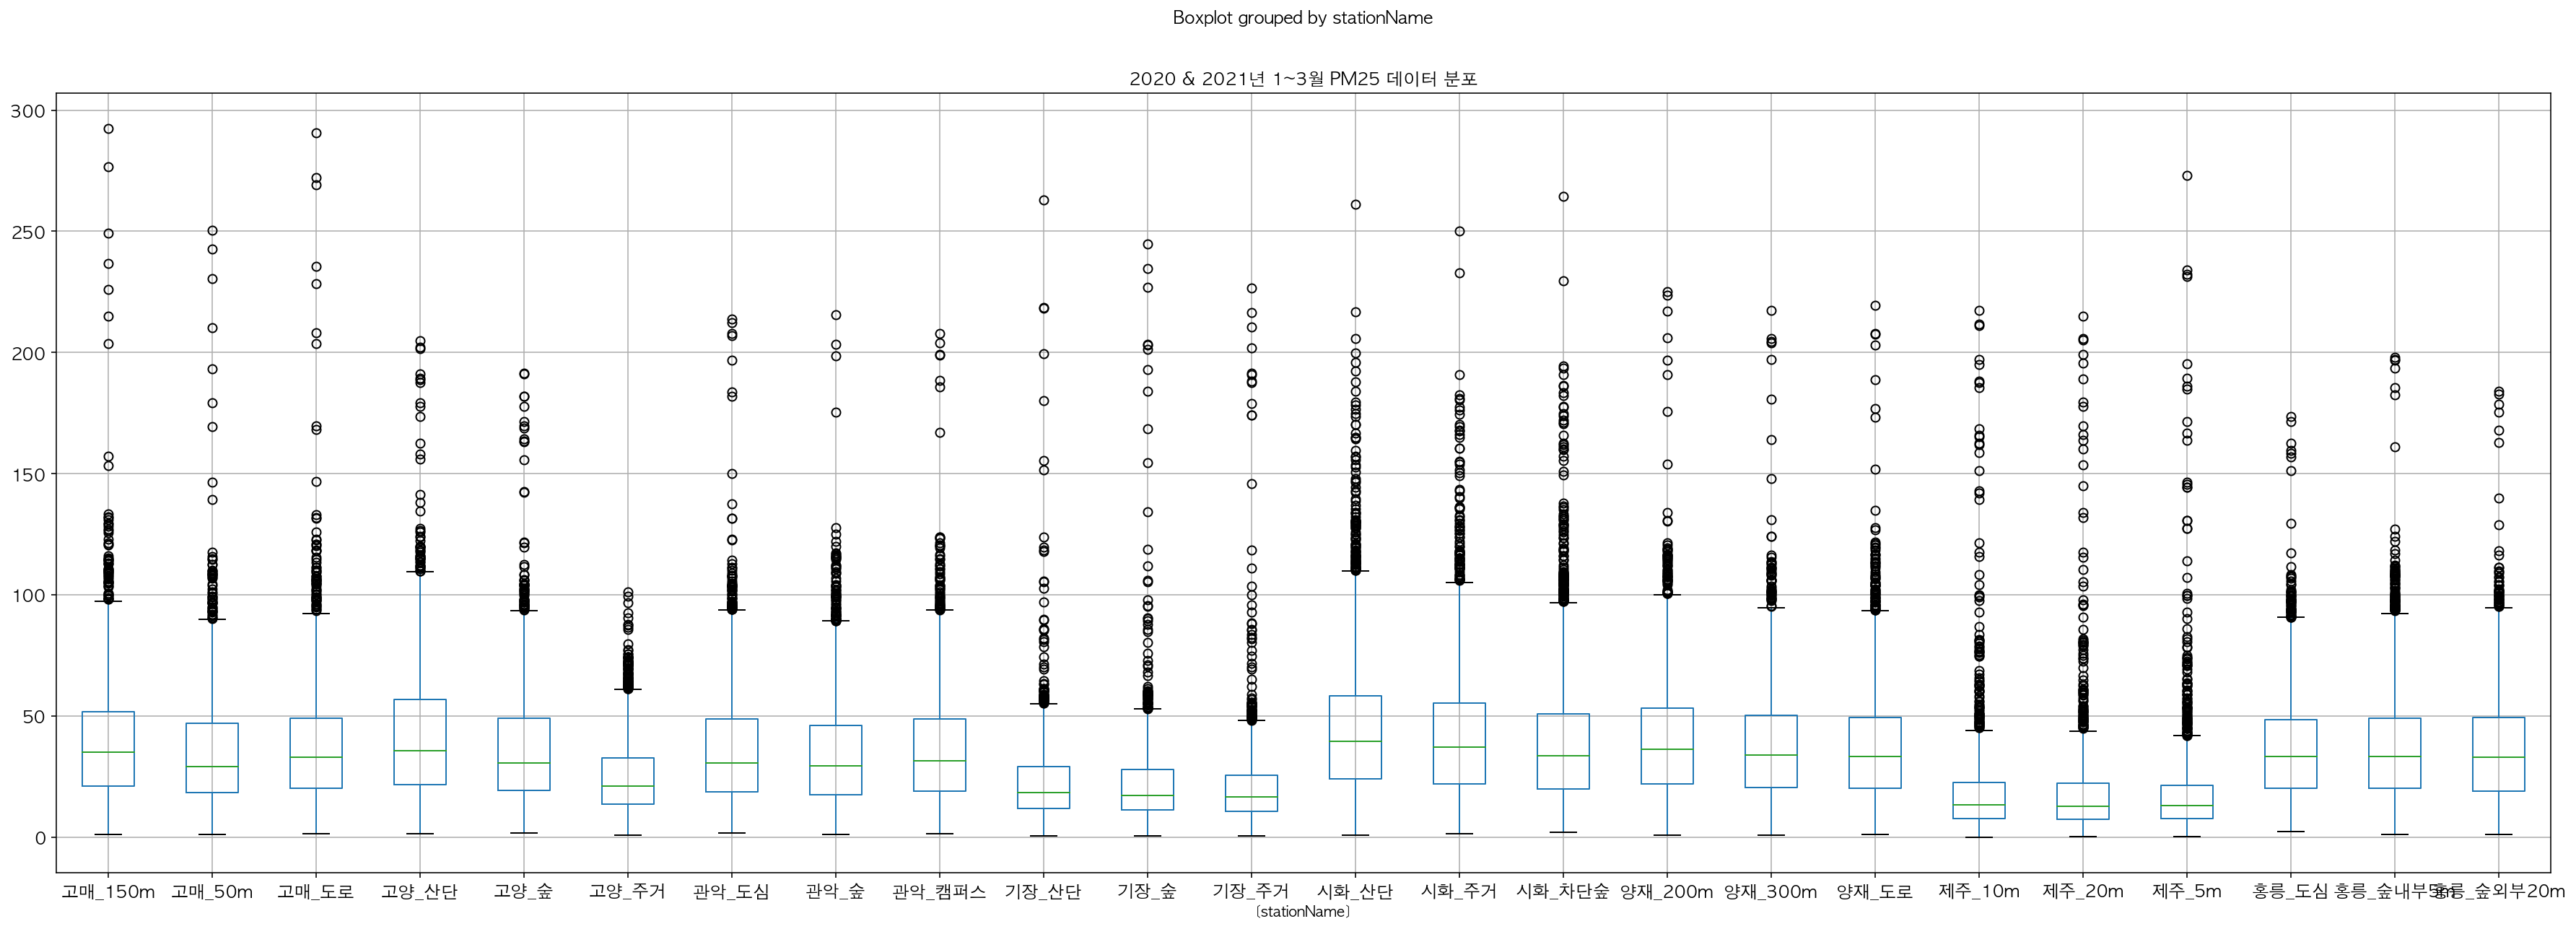

In [5]:
nifosPlot = nifos_filtered[[separatorColumn, dataColumn]].boxplot(by=separatorColumn, figsize=(30, 10), fontsize='large')
plotTitle = f'2020 & 2021년 1~3월 {dataColumn} 데이터 분포'
nifosPlot.set_title(plotTitle)
plt.savefig(plotTitle+'.png')
logger(f"Plot saved as {plotTitle}")

### Filtered data's summary

In [74]:
nifos_filtered_summary = nifos_filtered.groupby('stationName')['PM25'].describe().drop('min', axis=1).round(3)
display(nifos_filtered_summary)
saveDataframe(nifos_filtered_summary)

,count,mean,std,25%,50%,75%,max
stationName,,,,,,,
고매_150m,4251.0,38.780,23.755,21.040,34.967,51.617,292.500
고매_50m,2054.0,35.348,23.668,18.267,29.108,46.991,250.537
고매_도로,4341.0,36.920,22.820,20.039,33.067,49.067,290.700
고양_산단,2148.0,42.889,28.276,21.600,35.658,56.838,204.725
고양_숲,2160.0,37.492,24.937,19.307,30.583,48.983,191.392
고양_주거,2159.0,25.493,16.167,13.558,20.917,32.558,101.175
관악_도심,2077.0,37.456,25.698,18.650,30.433,48.733,213.750
관악_숲,2066.0,36.071,24.872,17.533,29.308,46.183,215.633
관악_캠퍼스,2125.0,38.062,25.667,18.953,31.367,48.833,207.883


[2021-06-06 16:11:24.339390] Dataframe saved as nifos_filtered_summary.csv


### Filtered data's montly summary between jan to mar

In [32]:
nifos_merged = pd.merge(left=nifos_filtered, right=weather, how='inner', on=[separatorColumn, datetimeColumn])
nifos_summary_monthly = nifos_merged.groupby([separatorColumn, nifos_merged[datetimeColumn].dt.month]).agg(['mean', 'median', 'max']).round(3)#.reset_index()
display(nifos_summary_monthly)
saveDataframe(nifos_summary_monthly)

PM25                  temperature         \
                                mean  median      max        mean median   
stationName measuredDatetime                                               
고매_150m     1                 35.151  32.181   99.714      -0.422 -0.163   
            2                 38.325  31.124  114.828       2.378  2.317   
            3                 42.698  40.292  292.500       7.711  7.455   
고매_50m      1                 28.422  23.800   80.233      -4.119 -4.000   
            2                 34.860  25.917  112.560       1.968  1.717   
...                              ...     ...      ...         ...    ...   
횡성_30m      2                 28.886  23.583  110.007      -2.580 -1.292   
            3                 29.359  27.225   97.200       3.655  3.625   
횡성_5m       1                 19.487  17.617   55.800      -7.098 -6.292   
            2                 26.665  21.067  100.617      -2.207 -1.018   
            3                 25.143  23.175   70.733       3.914  3.842   

                                     relativeHumidity                  \
                                 max             mean  median     max   
stationName measuredDatetime                                            
고매_150m     1                 13.683           62.399  64.018  95.750   
            2                 18.967           60.933  60.708  97.280   
            3                 22.700           59.838  60.092  97.650   
고매_50m      1                 13.440           57.304  58.750  92.917   
            2                 18.533           56.543  57.058  93.983   
...                              ...              ...     ...     ...   
횡성_30m      2                 13.150           58.278  56.492  98.450   
            3                 16.217           63.545  64.150  99.783   
횡성_5m       1                  3.433           54.293  49.717  90.600   
            2                 13.333           57.207  55.492  96.900   
            3                 16.867           62.676  63.408  98.567   

                             windSpeed                windWirection           \
                                  mean median     max          mean   median   
stationName measuredDatetime                                                   
고매_150m     1                    0.498  0.333   3.245       154.434  123.084   
            2                    0.609  0.388   2.706       173.444  180.796   
            3                    0.570  0.390   3.363       186.871  202.335   
고매_50m      1                    0.734  0.439   4.244       178.710  127.400   
            2                    0.851  0.490   3.446       196.954  247.034   
...                                ...    ...     ...           ...      ...   
횡성_30m      2                    1.974  1.953   6.524       222.992  240.339   
            3                    2.196  1.892  10.412       196.053  235.863   
횡성_5m       1                    0.768  0.633   2.167       214.049  183.807   
            2                    0.743  0.702   1.972       203.120  185.273   
            3                    0.857  0.782   3.045       186.745  176.816   

                                       
                                  max  
stationName measuredDatetime           
고매_150m     1                 359.992  
            2                 359.769  
            3                 359.997  
고매_50m      1                 359.516  
            2                 359.842  
...                               ...  
횡성_30m      2                 355.342  
            3                 359.904  
횡성_5m       1                 359.616  
            2                 359.414  
            3                 359.987  

[159 rows x 15 columns]

[2021-06-05 23:59:43.038319] Dataframe saved as nifos_summary_monthly.csv


### Calculate Recovery hour using series data

In [5]:
def getRecHour(df, separatorColumn, datetimeColumn, dataColumn, threshold=35):
    ''' comments '''
    import pandas as pd
    import numpy as np
    result = pd.DataFrame()
    for col in df[separatorColumn].unique():
        dfSub = df[df[separatorColumn]==col]
        dfSub['isOver'] = dfSub[dataColumn] >= threshold # Check data column is over threshold
        dfSub['duration'] = (dfSub[datetimeColumn]-dfSub[datetimeColumn].shift(periods=1, fill_value=0)).dt.components['hours'] # subtraction returns timedelta64
        dfSub['isRecovered'] = (dfSub['duration'] == 1) & (dfSub[dataColumn].shift(periods=1, fill_value=0) >= threshold) & (dfSub[dataColumn] < threshold)
        dfSub['recHour'] = np.where( (dfSub['duration'] == 1) & (dfSub['isOver']|dfSub['isRecovered']), # if condition
                                      dfSub['isOver'].cumsum(), # if true value
                                      None ) # else value
        dfSub['recHour'] = np.where( (~dfSub['isOver'])&dfSub['isRecovered'], dfSub['recHour'], None )
        dfSub_rechour = dfSub.copy()[dfSub['recHour']>0][[separatorColumn, datetimeColumn, 'recHour']]
        dfSub_rechour['recHour'] = dfSub_rechour['recHour'].sub(dfSub_rechour['recHour'].shift(periods=1, fill_value=0))
        result = pd.concat([result, dfSub_rechour])
        result[separatorColumn] = result[separatorColumn].astype(str)
        result['recHour'] = result['recHour'].astype(int)
    else:
        display(result)
        return result
        
nifos_rechour = getRecHour(nifos_filtered, separatorColumn, datetimeColumn, dataColumn)

,stationName,measuredDatetime,recHour
87,고매_150m,2020-01-04 15:00:00,75
110,고매_150m,2020-01-05 14:00:00,21
135,고매_150m,2020-01-06 15:00:00,23
277,고매_150m,2020-01-12 13:00:00,97
298,고매_150m,2020-01-13 10:00:00,2
...,...,...,...
213490,홍릉_숲외부20m,2021-03-21 12:00:00,14
213566,홍릉_숲외부20m,2021-03-24 16:00:00,41
213634,홍릉_숲외부20m,2021-03-27 12:00:00,52
213670,홍릉_숲외부20m,2021-03-29 00:00:00,3


In [6]:
rechour_summary = nifos_rechour.groupby(separatorColumn)['recHour'].agg(['mean', 'max', 'median']).round(3)
rechour_summary.to_csv('rechour_summary.csv')

rechour_summary_monthly = nifos_rechour.groupby([separatorColumn, nifos_rechour[datetimeColumn].dt.month]).agg(['mean', 'median', 'max']).round(3)
rechour_summary_monthly.to_csv('rechour_summary_monthly.csv')

<AxesSubplot:title={'center':'recHour'}, xlabel='[stationName]'>

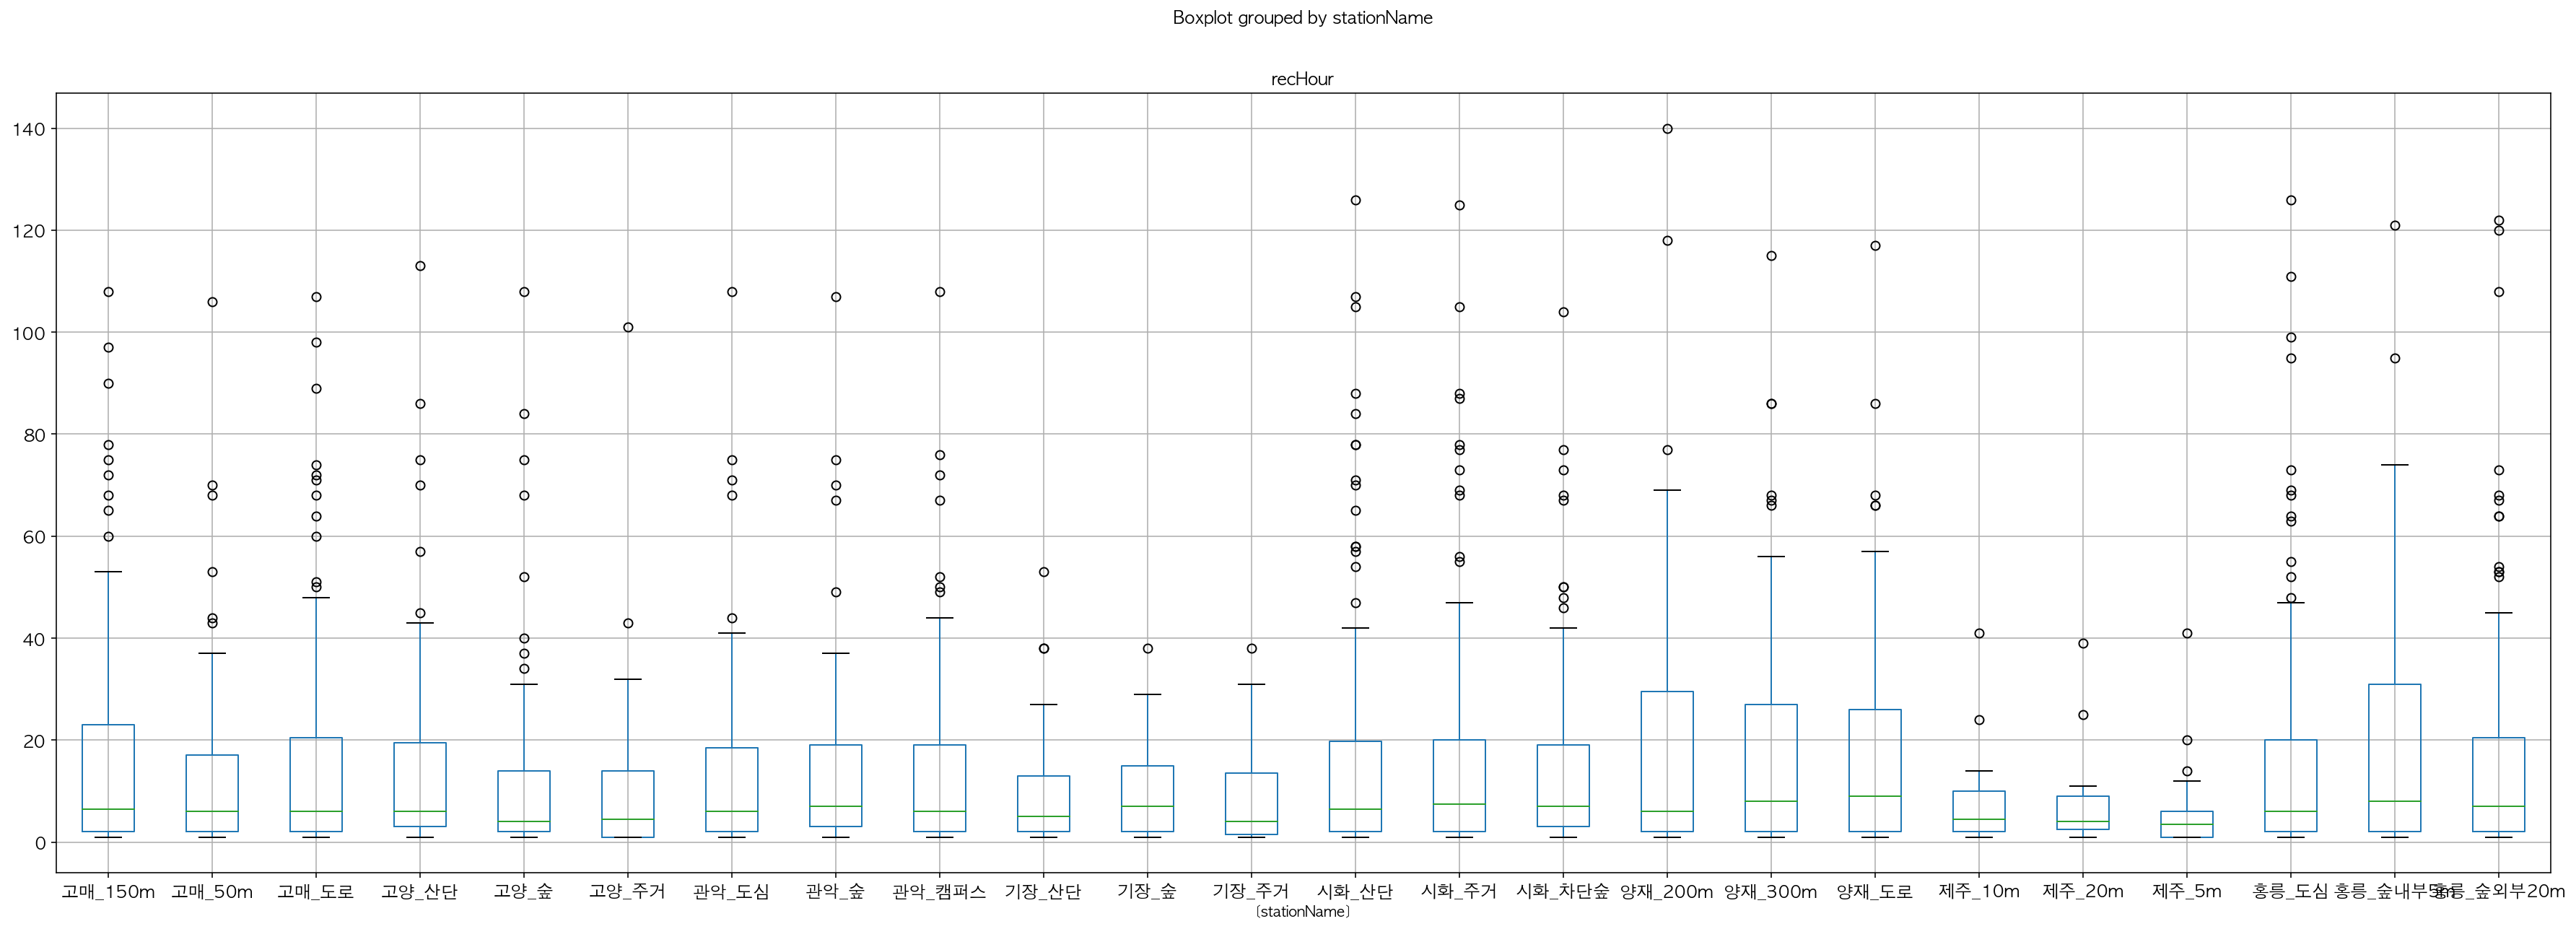

In [9]:
nifos_rechour[[separatorColumn, 'recHour']].boxplot(by=separatorColumn, figsize=(30, 10), fontsize='large')